The goal of this notebook is to compile a list of chord n-grams by frequency from the entire database.
My main goal is to do this counting chords as harmonically equivalent, but I will also do it more literally.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())
assert(len(known_chords) == len(set(known_chords))) # Validating no duplicates

# some examples of what the string labels for known chords look like
print(known_chords[0:10])

['C7', 'Cmaj7', 'C9', 'Cmaj9', 'Cmajs9', 'Cb9', 'Cb79', 'Cb7b9', 'C7b9', 'C7sus2']


In [4]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

In [5]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))

# replacing spaces with commons in all chords in all rows of the data
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [6]:
chord_data.sample(5)

,chords,genres
568380,"Dmin7,D7sus4,G,Emin,Dmin7,C,C,C,F,C,Emin,Amin,...",NaN
23168,"A,D,A,D,E,A,E,D,A,E,D,A,D,A,D,A,E,A,E,D,A,E,D,...","canzone d""classic italian pop""italian adult pop"
140067,"Cs,Gs,Fs,Gs,Fs,Cs,Gs,Fs,Gs,Fs,Cs,Gs,Fs,Gs,Fs,C...",NaN
58651,"D,G,D,G,D,G,D,G,D,G,D,G,D,G,D,G,D,G,D,G,D,G,D,...","indie poptimism""modern alternative rock""modern..."
58450,"Amin,G,Amin,G,Amin,G,Amin,G,Amin,G,Amin,G,Amin...","chanson""french rock"


In [7]:
list_of_chord_lists = list(chord_data.chords)

In [8]:
# method to transpose a chord in vector format
def transpose_chord_up(chord_vector, num_semitones):
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))
    
# method to return true if chord_1 and chord_2 are just tranposed versions of each other
def is_harmonic_equivalent(chord_1, chord_2):
    # if they have different numbers of notes, then we don't have to check if 
    # any of the transpositions are equal
    if sum(chord_1) != sum(chord_2):
        return False

    # if they have the same number of notes, just rotate through the 12 possible transpositions to check
    for i in range(12):
        if np.array_equal(chord_1, transpose_chord_up(chord_2, i)):
            return True

    return False

C = chord_degrees['C']
D = chord_degrees['D']
E = chord_degrees['E']
G = chord_degrees['G']
assert(is_harmonic_equivalent(C,D))
assert(is_harmonic_equivalent(C,E))
assert(is_harmonic_equivalent(D,E))
assert(is_harmonic_equivalent(C,G))

Cmaj7 = chord_degrees['Cmaj7']
Dmaj7 = chord_degrees['Dmaj7']
assert(is_harmonic_equivalent(Cmaj7,Dmaj7))

In [10]:
# function to convert a string of comma-separated chords into a matrix, where each row denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c] for c in chord_list])

def transpose_matrix_up(chord_matrix, num_semitones):
    # transpose the entire matrix up by a number of semitones
    # this just means applying transpose_chord_up to each row
    return np.array([transpose_chord_up(row,num_semitones) for row in chord_matrix])

def is_harmonic_equivalent_matrix(chord_matrix_1, chord_matrix_2):
    # return true if chord_matrix_1 and chord_matrix_2 are just tranposed versions of each other

    # some basic checks to skip some looping when we can rule that out already
    #if chord_matrix_1.shape != chord_matrix_2.shape:
    #    return False

    for i in range(len(chord_matrix_1)):
        if chord_matrix_1[i].sum() != chord_matrix_2[i].sum():
            return False

    # loop to check if they're the same
    for i in range(12):
        if np.array_equal(chord_matrix_1, transpose_matrix_up(chord_matrix_2, i)):
            return True

    return False

CD = string_to_chord_matrix('C,D')
DE = string_to_chord_matrix('D,E')
print(CD)
print(DE)
assert(is_harmonic_equivalent_matrix(CD,DE))

[[1 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 1 0 0]]
[[0 0 1 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 1]]


In [11]:
def n_grams(n):
    # return a counter object of n-grams, ignoring harmonic equivalence
    chord_n_gram_counter = Counter()
    for song in list_of_chord_lists:
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            pair = ','.join(song_as_list[i:i+n])
            chord_n_gram_counter[pair] += 1
    return chord_n_gram_counter

In [12]:
def unique_n_grams(chord_n_gram_counter, output_messages=False, countdown=False):
    # return a counter object of harmonically unique n-grams
    # this will be a dictionary where keys are (harmonically unique) n-grams, and values are numbers of occurences in the database

    # make a deep copy of the input so we don't modify the original
    chord_n_gram_counter_copy = copy.deepcopy(chord_n_gram_counter)

    if output_messages:
        print("Initial length of numbers of n-grams with duplicates:",len(chord_n_gram_counter_copy))
        print()
    
    # we'll build up a counter of uniques
    unique_n_gram_counter = Counter()

    while len(chord_n_gram_counter_copy) > 0:
        n_gram_1 = chord_n_gram_counter_copy.most_common(1)[0][0]
        matrix_1 = string_to_chord_matrix(n_gram_1)
        
        # initialize a list of equivalent n-grams
        equivalent_n_grams = [n_gram_1]
        running_total = chord_n_gram_counter_copy[n_gram_1]

        # delete the current n-gram under consideration so that we don't count it as an equivalent to itself a second time
        del chord_n_gram_counter_copy[n_gram_1]
        
        # go through and find all harmonically equivalent chords to the most common chord left
        for n_gram_2 in chord_n_gram_counter_copy:
            matrix_2 = string_to_chord_matrix(n_gram_2)            
            if is_harmonic_equivalent_matrix(matrix_1, matrix_2):
                equivalent_n_grams.append(n_gram_2)
                running_total = running_total + chord_n_gram_counter_copy[n_gram_2]
    
        # set the value in the new counter to be the accumulated sum
        unique_n_gram_counter[n_gram_1] = running_total

        # go through chord_counts_copy and delete all the chords that were just added to the unique chord counter
        for e in equivalent_n_grams:
            del chord_n_gram_counter_copy[e]

        if output_messages:
            print("n-gram under consideration:",n_gram_1)
            print("Equivalent n-grams:",equivalent_n_grams)
            print("Number of equivalent n-grams:",len(equivalent_n_grams))
            print("New length of non-unique n-grams to check:",len(chord_n_gram_counter_copy))
            print("Updated list of unique n-grams:",unique_n_gram_counter)
            print()

        if countdown:
            print("Remaining n-grams:",len(chord_n_gram_counter_copy))

    return unique_n_gram_counter

In [13]:
# visualize output of computing raw and unique n-grams
def visualize(n, pie_slices = -1):
    # compute the raw n-grams
    n_gram_counter_raw = n_grams(n)

    # compute the unique n-grams
    n_gram_counter_unique = unique_n_grams(n_gram_counter_raw, output_messages=False, countdown=True)

    # print some basic info
    print("n =",n)
    print("Raw number of distinct n-grams:",len(n_gram_counter_raw))
    print("Number of harmonically unique n-grams:",len(n_gram_counter_unique))
    print("Top 10 most common raw n-grams:",n_gram_counter_raw.most_common(10))
    print("Top 10 most common harmonically unique n-grams:",n_gram_counter_unique.most_common(10))

    # set up some subplots
    fig, axes = plt.subplots(nrows = 2,
                             ncols = 2,
                             figsize = (10,10))
    
    # make a pie chart of top raw n-grams, using pie_slices if provided
    if pie_slices == -1:
        # default value, so plot all the slices
        x_raw = n_gram_counter_raw.values()
        labels_raw = n_gram_counter_raw.keys()
    else:
        # pie chart with only the top most common n-grams
        most_common = Counter(dict(n_gram_counter_raw.most_common(pie_slices)))
        x_raw = most_common.values()
        labels_raw = most_common.keys()
    axes[0,0].pie(x = list(x_raw), labels = list(labels_raw))
    axes[0,0].set_title('Raw n-grams')
    
    # make a pie chart of top unique n-grams, using pie_slices if provided
    if pie_slices == -1: 
        # default value, so plot all the slices
        x_unique = n_gram_counter_unique.values()
        labels_unique = n_gram_counter_unique.keys()
    else:
        # pie chart with only the top most common n-grams
        most_common = Counter(dict(n_gram_counter_unique.most_common(pie_slices)))
        x_unique = most_common.values()
        labels_unique = most_common.keys()
    axes[0,1].pie(x = list(x_unique), labels = list(labels_unique))
    axes[0,1].set_title('Harmonically unique n-grams')

    # make a log plot of frequencies of raw n-grams
    axes[1,0].scatter(x = np.arange(len(n_gram_counter_raw.values())),
                      y = np.log(np.sort(list(n_gram_counter_raw.values()))),
                      marker='.')
    axes[1,0].set_title('Log frequencies of raw n-grams')
    axes[1,0].set_ylabel('log of frequency')

    # make a log plot of frequencies of unique n-grams
    axes[1,1].scatter(x = np.arange(len(n_gram_counter_unique.values())),
                      y = np.log(np.sort(list(n_gram_counter_unique.values()))),
                      marker='.')
    axes[1,1].set_title('Log frequencies of unique n-grams')
    
    plt.show()

Remaining n-grams: 729
Remaining n-grams: 712
Remaining n-grams: 695
Remaining n-grams: 661
Remaining n-grams: 644
Remaining n-grams: 627
Remaining n-grams: 610
Remaining n-grams: 576
Remaining n-grams: 548
Remaining n-grams: 531
Remaining n-grams: 514
Remaining n-grams: 497
Remaining n-grams: 464
Remaining n-grams: 430
Remaining n-grams: 413
Remaining n-grams: 396
Remaining n-grams: 379
Remaining n-grams: 318
Remaining n-grams: 301
Remaining n-grams: 283
Remaining n-grams: 266
Remaining n-grams: 249
Remaining n-grams: 232
Remaining n-grams: 217
Remaining n-grams: 201
Remaining n-grams: 184
Remaining n-grams: 164
Remaining n-grams: 152
Remaining n-grams: 140
Remaining n-grams: 135
Remaining n-grams: 120
Remaining n-grams: 106
Remaining n-grams: 94
Remaining n-grams: 79
Remaining n-grams: 64
Remaining n-grams: 48
Remaining n-grams: 36
Remaining n-grams: 24
Remaining n-grams: 22
Remaining n-grams: 16
Remaining n-grams: 13
Remaining n-grams: 12
Remaining n-grams: 5
Remaining n-grams: 4
Re

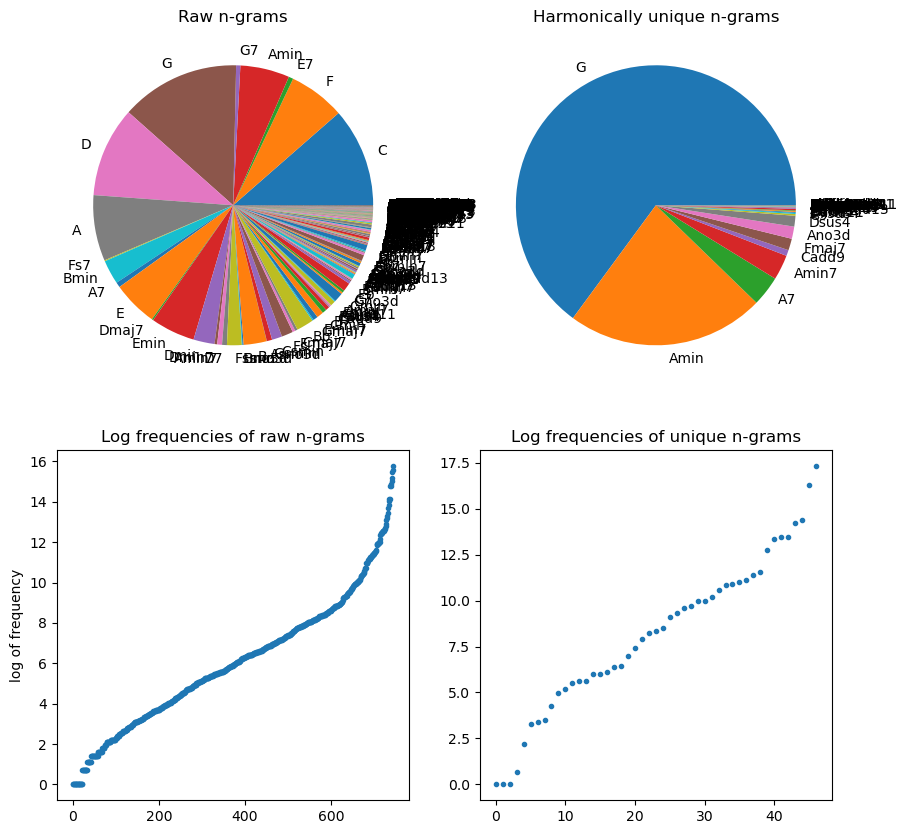

In [14]:
visualize(1)

In [15]:
visualize(2)

Remaining n-grams: 64173
Remaining n-grams: 64147
Remaining n-grams: 64122
Remaining n-grams: 64097
Remaining n-grams: 64072
Remaining n-grams: 64049
Remaining n-grams: 64024
Remaining n-grams: 64000
Remaining n-grams: 63976
Remaining n-grams: 63954
Remaining n-grams: 63928
Remaining n-grams: 63902
Remaining n-grams: 63876
Remaining n-grams: 63850
Remaining n-grams: 63824
Remaining n-grams: 63802
Remaining n-grams: 63776
Remaining n-grams: 63753
Remaining n-grams: 63729
Remaining n-grams: 63703
Remaining n-grams: 63677
Remaining n-grams: 63653
Remaining n-grams: 63631
Remaining n-grams: 63608
Remaining n-grams: 63586
Remaining n-grams: 63564
Remaining n-grams: 63537
Remaining n-grams: 63515
Remaining n-grams: 63489
Remaining n-grams: 63466
Remaining n-grams: 63443
Remaining n-grams: 63401
Remaining n-grams: 63356
Remaining n-grams: 63313
Remaining n-grams: 63291
Remaining n-grams: 63266
Remaining n-grams: 63242
Remaining n-grams: 63195
Remaining n-grams: 63170
Remaining n-grams: 63126


KeyboardInterrupt: 